<a href="https://colab.research.google.com/github/PranavMahajan25/Neural-ODE/blob/master/ODEnet_Mimic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cloning the repo, setting up the lib

In [0]:
!git clone https://github.com/rtqichen/torchdiffeq.git

Cloning into 'torchdiffeq'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 124 (delta 5), reused 10 (delta 2), pack-reused 106
Receiving objects: 100% (124/124), 690.88 KiB | 2.71 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [0]:
!cd torchdiffeq && pip install -e .

Obtaining file:///content/torchdiffeq
  Running setup.py develop for torchdiffeq


In [0]:
!ls torchdiffeq/torchdiffeq

_impl  __init__.py


In [0]:
#!python torchdiffeq/examples/ode_demo.py 

#Preliminaries, importing, intialising ODE and solving it for real Y values

In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [0]:
from torchdiffeq.torchdiffeq import odeint_adjoint as odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
data_size =1000
batch_size =20
batch_time =10

In [0]:
true_y0 = torch.tensor([[2., 0.]]) #init conds
t = torch.linspace(0., 25., data_size)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]) # defining system of diff equations

In [0]:
b= torch.tensor([[1.0,1.0]])
torch.mm(b**3,true_A)
# b is 1x2 and true_A is 2x2 thus output is 1x2, just a recap of matrix multiplication

tensor([[-2.1000,  1.9000]])

In [0]:
class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y**3, true_A)

diff eqns:

d(y1)/dt = -0.1*(y1^3) -2*(y2^3) 

d(y2)/dt = 2*(y1^3) -0.1*(y2^3)

i.e.

[y1', y2'] = [y1^3 , y2^3] * [ [-0.1, 2], [-2, 0.1] ]

In [0]:
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')
#literally solves the ode for the true vals, we'll use these later in the loss function to train a neural net to predict this solution to an ODE

In [0]:
true_y

tensor([[[ 2.0000,  0.0000]],

        [[ 1.9795,  0.3944]],

        [[ 1.9494,  0.7742]],

        ...,

        [[-0.4418,  0.2883]],

        [[-0.4427,  0.2839]],

        [[-0.4436,  0.2795]]])

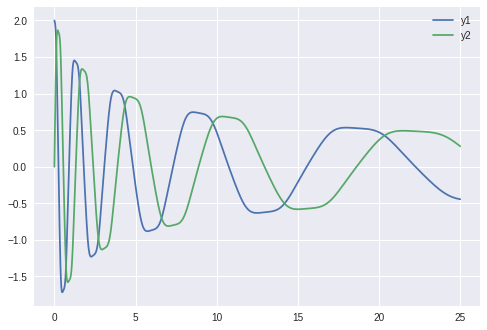

In [0]:
plt.figure()
plt.plot(t.numpy(), true_y[:,:, 0].numpy(), label='y1')
plt.plot(t.numpy(), true_y[:,:, 1].numpy(), label='y2')
plt.legend()

#Familiarizing with matrix operations and shapes required in creating batches to train eventually
## This is just for a deeper understanding, feel free to skip to def get_batch():

In [0]:
true_y.shape

torch.Size([1000, 1, 2])

In [0]:
true_y[[0,1,2,3,4]] #first 5 y values

tensor([[[2.0000, 0.0000]],

        [[1.9795, 0.3944]],

        [[1.9494, 0.7742]],

        [[1.8867, 1.1273]],

        [[1.7639, 1.4297]]])

In [0]:
#This cell is just dedicated to understand individual operations in the future cell
s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
#s #size 20 
batch_y0=true_y[s]
batch_y0.shape #size 20x1x2 i.e. sampled 20 random pts from (1000-10 = 990) true y vals

torch.Size([20, 1, 2])

In [0]:
batch_t = t[:batch_time] # (T)
batch_t #size 10 
# just first 10 time axis - points out of 1000

tensor([0.0000, 0.0250, 0.0501, 0.0751, 0.1001, 0.1251, 0.1502, 0.1752, 0.2002,
        0.2252])

In [0]:
batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0) # (T, M, D)
batch_y.shape

torch.Size([10, 20, 1, 2])

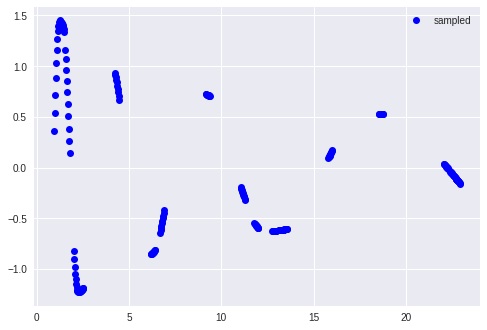

In [0]:
#visualise
batch_of20 = np.arange(batch_size)
t_sample=[]
batch_sample=[]

for i in batch_of20:
  t_sample = np.append(t_sample, t[s[i].item() : s[i].item() + batch_time].numpy())
  batch_sample = np.append(batch_sample, batch_y[:,i,0,0].numpy())


plt.figure()
plt.plot(t_sample, batch_sample , 'bo', label='sampled' )
plt.legend()

# Writing Neural net architecture using Neural ODEs and training it!

In [0]:
def get_batch():
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = true_y[s] # (M, D)
  batch_t = t[:batch_time] # (T)
  batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
  return batch_y0, batch_t, batch_y


In [0]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )
        
        # 2 i/p and o/p coz system of 2 eqnns

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y): # Note that forward pass has time t as input as well, as compared to regular neural nets!
        return self.net(y**3)

  

In [0]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
            self.val = val

In [0]:
ii = 0
test_freq=20
niters=2000
func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t)    #passing class ODEFunc which is of type nn.module as diff eq to solve using odeint
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
          with torch.no_grad():
              pred_y = odeint(func, true_y0, t)
              loss = torch.mean(torch.abs(pred_y - true_y))
              print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
              ii += 1

    end = time.time()

Iter 0020 | Total Loss 0.675882
Iter 0040 | Total Loss 0.659509
Iter 0060 | Total Loss 0.590153
Iter 0080 | Total Loss 0.400313
Iter 0100 | Total Loss 0.756425
Iter 0120 | Total Loss 0.816617
Iter 0140 | Total Loss 0.456125
Iter 0160 | Total Loss 0.416209
Iter 0180 | Total Loss 0.577256
Iter 0200 | Total Loss 0.779983
Iter 0220 | Total Loss 0.289838
Iter 0240 | Total Loss 0.293863
Iter 0260 | Total Loss 0.408011
Iter 0280 | Total Loss 0.431037
Iter 0300 | Total Loss 0.191076
Iter 0320 | Total Loss 0.643463
Iter 0340 | Total Loss 0.180766
Iter 0360 | Total Loss 0.228136
Iter 0380 | Total Loss 0.542087
Iter 0400 | Total Loss 0.178996
Iter 0420 | Total Loss 0.480825
Iter 0440 | Total Loss 0.363515
Iter 0460 | Total Loss 0.419496
Iter 0480 | Total Loss 0.147032
Iter 0500 | Total Loss 0.342559
Iter 0520 | Total Loss 0.395337
Iter 0540 | Total Loss 0.217566
Iter 0560 | Total Loss 0.183632
Iter 0580 | Total Loss 0.189132
Iter 0600 | Total Loss 0.535295
Iter 0620 | Total Loss 0.403465
Iter 064

In [0]:
pred_y = odeint(func, true_y0, t)
pred_y.detach()

tensor([[[ 2.0000,  0.0000]],

        [[ 1.9861,  0.3158]],

        [[ 1.9692,  0.6271]],

        ...,

        [[-0.4521,  0.2374]],

        [[-0.4522,  0.2327]],

        [[-0.4523,  0.2279]]])

No handles with labels found to put in legend.


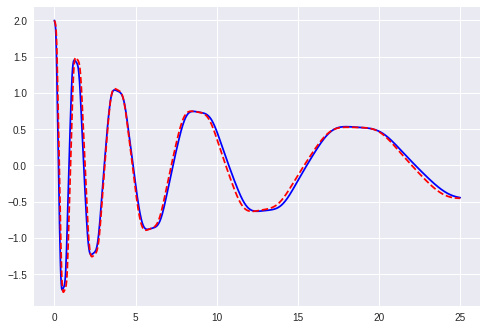

In [0]:
plt.figure()
plt.plot(t.numpy(), true_y[:,:, 0].numpy(), 'b-')
plt.plot(t.numpy(), pred_y[:,:, 0].detach().numpy(), 'r--')
plt.legend()

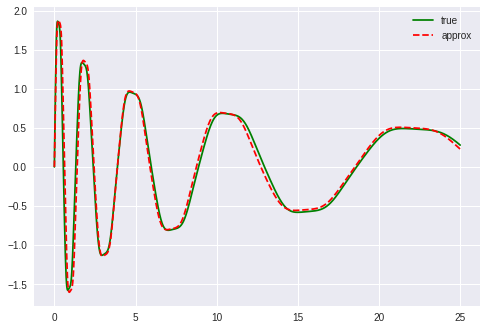

In [0]:
plt.figure()
plt.plot(t.numpy(), true_y[:,:, 1].numpy(), 'g-',label='true' )
plt.plot(t.numpy(), pred_y[:,:, 1].detach().numpy(),'r--',  label='approx' )
plt.legend()